In [18]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# inputs: 
# v, an array of payoffs for each action at a given turn
# epsilon, the learning rate
# h, the range of the payoffs
# outputs:
# weights, weights for each action at a given turn
# pi, optimal probabilities for picking each action at a given turn
def exponential_weights(v, epsilon, h):
    V = np.cumsum(v, axis=1)
    weights = np.power((1 + epsilon), V[:, :-1]/h)
    # because we're referencing the previous column, the first
    # column of ones gets removed so we need to add it back
    weights = np.insert(weights, 0, np.ones(v.shape[0]), axis=1)
    pi = np.divide(weights, np.sum(weights, axis=0))
    return weights, pi

# a
def adversarial_fair_payoffs(actions, rounds):
    V = np.zeros(shape=[actions, ])
    payoffs = np.zeros(shape=[actions, rounds])
    for i in range(rounds):
        x = np.random.uniform(0,1)
        j_star = np.argmin(V)
        payoffs[j_star][i] = x
        V[j_star] += x

    return payoffs

#b
def bernoulli_payoffs(actions, rounds):
    probabilities = list(map(lambda a: np.random.uniform(0, 0.5), np.zeros(shape=[actions, ])))
    payoffs = np.zeros(shape=[actions, rounds])
    for i in range(rounds):
        for j in range(actions):
            if np.random.uniform(0, 1) < probabilities[j]:
                payoffs[j][i] = 1
               
    return payoffs

#c
def bulls_data():
    data = np.genfromtxt('BullsData.csv', delimiter=',')
    # remove the dates/player names
    data = np.delete(data, 0, axis=0) 
    data = np.delete(data, -1, axis=0) 
    data = np.delete(data, 0, axis=1)
    
    return data

#helper for beta payoffs -- computes results of beta function
def beta_function(a, b):
    num = (math.factorial(a - 1)) * (math.factorial(b - 1))
    den = math.factorial(a + b - 1)

    return num / den

#d
def beta_payoffs(actions, rounds):
    alpha = 90
    beta = 10
    payoffs = np.zeros(shape=[actions, rounds])
    for i in range(rounds):
        for j in range(actions):
            # do something
            x = np.random.uniform(0, 1)
            prob = (1 / beta_function(alpha, beta)) * np.power(x, alpha - 1) *  np.power(1 - x, beta - 1)
            if np.random.uniform(0, 1) < prob:
                payoffs[j][i] = 1
    return payoffs

In [2]:
def random_pick(probability_array):
    random_number = random.random()
    cumulative_probability = 0.0
    for index, probability in enumerate(probability_array):
        cumulative_probability += probability
        if random_number < cumulative_probability:
            return index
    return len(probability_array) - 1

def regret(payoffs, EW):
    optimal_sum = 0
    EW_sum = 0
    n = payoffs.shape[1]

    for i in range(n):
        j = np.argmax(payoffs[:, i])
        optimal_sum += payoffs[j][i]
        j_i = random_pick(EW[:, i]) # randomly pick an action according to the EW probabilities
        EW_sum += payoffs[j_i, i]

    # print(1 / n * (optimal_sum-EW_sum))
    return 1 / n * (optimal_sum-EW_sum)

def write_dictionary_to_excel(input_dictionary):
    from openpyxl import Workbook

    wb = Workbook()

    for key, arr in input_dictionary.items():
        sheet = wb.create_sheet(title = key)
        for i, row in enumerate(arr):
            for j, col in enumerate(row):
                sheet.cell(row=i+1, column=j+1, value=col)

    wb.save('results.xlsx') 

In [20]:
def get_graphs_for_parameters():
    N = 10
    STEP = 250
    END = 10000
    a_rounds_regret = np.zeros(int(END/STEP))
    b_rounds_regret = np.zeros(int(END/STEP))
    actions = 20
    for rounds in range(STEP, END, STEP):
        # average results from N samples
        a_sum = 0
        b_sum = 0
        epsilon = np.power(np.log(actions)/rounds, 1/2)
        for i in range(N):
            a_payoffs = adversarial_fair_payoffs(actions, rounds)
            b_payoffs = bernoulli_payoffs(actions, rounds)
            _, a_EW = exponential_weights(a_payoffs, epsilon, 1)
            _, b_EW = exponential_weights(b_payoffs, epsilon, 1)
            a_sum += regret(a_payoffs, a_EW)
            b_sum += regret(b_payoffs, b_EW)
        a_rounds_regret[int(rounds/STEP)] = a_sum/N
        b_rounds_regret[int(rounds/STEP)] = b_sum/N

    plt.plot(list(range(0, END, STEP)), a_rounds_regret, color="red", label="Adversarial Fair Payoff")
    plt.plot(list(range(0, END, STEP)), b_rounds_regret, color="blue", label="Bernoulli Payoff")
    plt.xlabel('Rounds')
    plt.ylabel('Regret')
    plt.title('Regret vs Rounds')
    plt.legend()
    plt.show()

    STEP = 4
    END = 100
    a_actions_regret = np.zeros(int(END/STEP))
    b_actions_regret = np.zeros(int(END/STEP))
    rounds = 20
    for actions in range(STEP, END, STEP):
        # average results from N samples
        a_sum = 0
        b_sum = 0
        epsilon = np.power(np.log(actions)/rounds, 1/2)
        for _ in range(N):
            a_payoffs = adversarial_fair_payoffs(actions, rounds)
            b_payoffs = bernoulli_payoffs(actions, rounds)
            _, a_EW = exponential_weights(a_payoffs, epsilon, 1)
            _, b_EW = exponential_weights(b_payoffs, epsilon, 1)
            a_sum += regret(a_payoffs, a_EW)
            b_sum += regret(b_payoffs, b_EW)
        a_actions_regret[int(actions/STEP)] = a_sum/N
        b_actions_regret[int(actions/STEP)] = b_sum/N
        
    plt.plot(list(range(0, END, STEP)), a_actions_regret, color="red", label="Adversarial Fair Payoff")
    plt.plot(list(range(0, END, STEP)), b_actions_regret, color="blue", label="Bernoulli Payoff")
    plt.xlabel('Actions')
    plt.ylabel('Regret')
    plt.title('Regret vs Actions')
    plt.legend()
    plt.show()

def analyze_payoffs(step, end, divisor=1):
    N = 10
    regrets = {
        "Adversarial Fair": np.zeros(int(end/step)), 
        "Bernoulli": np.zeros(int(end/step)), 
        "Chicago Bulls": np.zeros(int(end/step)), 
        "Beta Distribution": np.zeros(int(end/step))
    }
    actions = 20
    rounds = 100
    for epsilon in range(0, end, step):
        # average results from N samples
        epsilon = float(epsilon)/divisor
        a_sum = 0
        b_sum = 0
        c_sum = 0
        d_sum = 0
        for i in range(N):
            a_payoffs = adversarial_fair_payoffs(actions, rounds)
            b_payoffs = bernoulli_payoffs(actions, rounds)
            c_payoffs = bulls_data()
            d_payoffs = beta_payoffs(actions, rounds)
            _, a_EW = exponential_weights(a_payoffs, epsilon, 1)
            _, b_EW = exponential_weights(b_payoffs, epsilon, 1)
            _, c_EW = exponential_weights(c_payoffs, epsilon, 44) #44 is the max points scored in the data
            _, d_EW = exponential_weights(d_payoffs, epsilon, 1)
            a_sum += regret(a_payoffs, a_EW)
            b_sum += regret(b_payoffs, b_EW)
            c_sum += regret(c_payoffs, c_EW)
            d_sum += regret(d_payoffs, d_EW)
        regrets["Adversarial Fair"][int(np.round(epsilon*step*divisor))] = a_sum/N
        regrets["Bernoulli"][int(np.round(epsilon*step*divisor))] = b_sum/N
        regrets["Chicago Bulls"][int(np.round(epsilon*step*divisor))] = c_sum/44/N
        regrets["Beta Distribution"][int(np.round(epsilon*step*divisor))] = d_sum/N

    return regrets

def regret_for_optimal_epsilon():
    N = 100
    actions = 20
    rounds = 100
    a_sum = 0
    b_sum = 0
    c_sum = 0
    d_sum = 0
    c_payoffs = bulls_data()
    epsilon = np.sqrt(np.log(actions)/rounds)
    bulls_eps = np.sqrt(np.log(c_payoffs.shape[0])/c_payoffs.shape[1])
    for i in range(N):
        a_payoffs = adversarial_fair_payoffs(actions, rounds)
        b_payoffs = bernoulli_payoffs(actions, rounds)
        d_payoffs = beta_payoffs(actions, rounds)
        _, a_EW = exponential_weights(a_payoffs, epsilon, 1)
        _, b_EW = exponential_weights(b_payoffs, epsilon, 1)
        _, c_EW = exponential_weights(c_payoffs, bulls_eps, 44) #44 is the max points scored in the data
        _, d_EW = exponential_weights(d_payoffs, epsilon, 1)
        a_sum += regret(a_payoffs, a_EW)
        b_sum += regret(b_payoffs, b_EW)
        c_sum += regret(c_payoffs, c_EW)/44
        d_sum += regret(d_payoffs, d_EW)
    print(f"Optimal Adversarial Fair Learning Rate {epsilon} gives regret {a_sum/N}")
    print(f"Optimal Bernoulli Learning Rate {epsilon} gives regret {b_sum/N}")
    print(f"Optimal Bulls Data Learning Rate {bulls_eps} gives regret {c_sum/N}")
    print(f"Optimal Beta Distribution Learning Rate {epsilon} gives regret {d_sum/N}")

def plot_regrets(regrets, step, end, divisor=1):
    print(np.argmin(regrets["Adversarial Fair"]), np.min(regrets["Adversarial Fair"]))
    print(np.argmin(regrets["Bernoulli"]), np.min(regrets["Bernoulli"]))
    print(np.argmin(regrets["Chicago Bulls"]), np.min(regrets["Chicago Bulls"]))
    print(np.argmin(regrets["Beta Distribution"]), np.min(regrets["Beta Distribution"]))
    # print(regrets)

    for payoff in regrets.keys():
        plt.plot(np.divide(list(range(0, end, step)), divisor), regrets[payoff], label=payoff)
    plt.xlabel('Epsilon')
    plt.ylabel('Regret')
    plt.title('Regret vs Epsilon')
    plt.legend()
    plt.show()

In [ ]:
# testing
def test_example_from_class():
    weights, pi = exponential_weights(np.array([[1, 1, 0, 0], [0, 0, 1, 1]]), 1, 1)
    assert np.array_equal(weights, [[1, 2, 4, 4], [1, 1, 1, 2]])
    assert np.array_equal(pi, [[1/2, 2/3, 4/5, 2/3], [1/2, 1/3, 1/5, 1/3]])

test_example_from_class()
print("Test succeeded")

Test succeeded


In [ ]:
step = 1
end = 100
less_than_one_regrets = analyze_payoffs(step, end, divisor=100)
one_to_one_hundred_regrets = analyze_payoffs(step, end)

/var/folders/75/ngc871gn2455wfxht31yhqjh0000gn/T/ipykernel_36179/1824006381.py:15: RuntimeWarning: overflow encountered in power
  weights = np.power((1 + epsilon), V[:, :-1]/h)
/var/folders/75/ngc871gn2455wfxht31yhqjh0000gn/T/ipykernel_36179/1824006381.py:19: RuntimeWarning: invalid value encountered in divide
  pi = np.divide(weights, np.sum(weights, axis=0))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


8 0.4740407941349417
92 0.5271100000000001
93 0.32408008658008647
85 0.8070100000000001


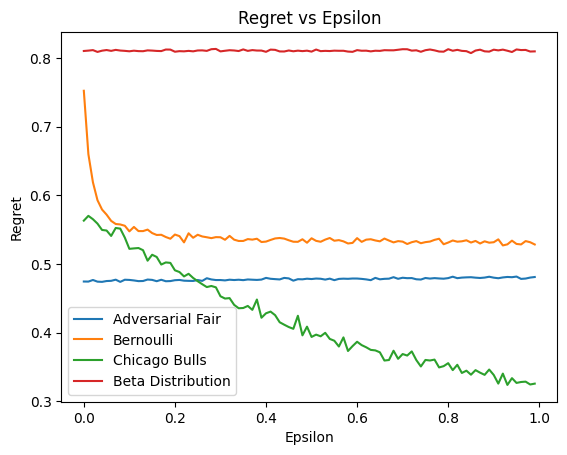

In [ ]:
# write_dictionary_to_excel(regrets)
plot_regrets(less_than_one_regrets, step, end, divisor=100)

0 0.4764920267768774
3 0.52876
55 0.20498917748917753
36 0.8074299999999996


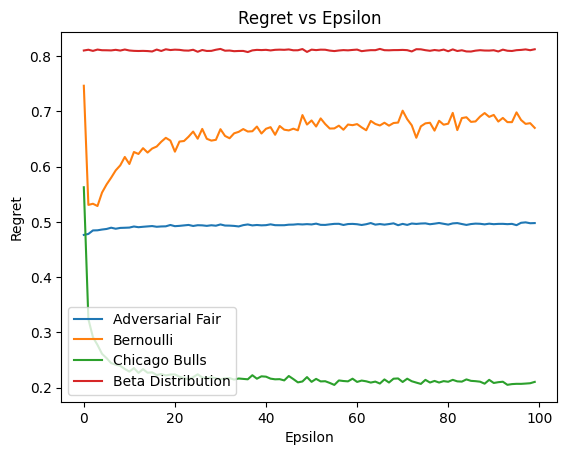

In [ ]:
plot_regrets(one_to_one_hundred_regrets, step, end)

In [21]:
regret_for_optimal_epsilon()

Optimal Adversarial Fair Learning Rate 0.17308183826022852 gives regret 0.47818518432933566
Optimal Bernoulli Learning Rate 0.17308183826022852 gives regret 0.6355000000000002
Optimal Bulls Data Learning Rate 0.3633566215061596 gives regret 0.44244588744588725
Optimal Beta Distribution Learning Rate 0.17308183826022852 gives regret 0.8092
